In [64]:
import math
from typing import Tuple

import dgl
import torch 
from ogb.utils import smiles2graph
from ogb.lsc import DglPCQM4MDataset
import networkx as nx

import torch.nn as nn
import torch.nn.functional as F

import tsensor
from timeit import default_timer

In [2]:
dataset = DglPCQM4MDataset(root='/home/ksadowski/datasets', smiles2graph=smiles2graph)

In [3]:
dataset

DglPCQM4MDataset(3803453)

Num nodes: 17
Num edges: 51
Num source nodes: 17


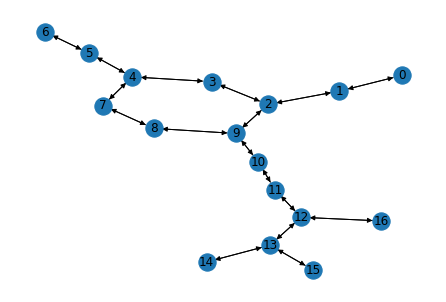

In [4]:
# molecule = dgl.to_homogeneous(dataset[2736][0], ndata=dataset[2736][0].ndata, edata=dataset[2736][0].edata, store_type=False)
molecule = dgl.to_homogeneous(dataset[1][0], ndata=dataset[1][0].ndata, edata=dataset[1][0].edata, store_type=False)
molecule = dgl.add_self_loop(molecule)
molecule_lg = dgl.line_graph(molecule, backtracking=False)

print(f'Num nodes: {molecule.num_nodes()}')
print(f'Num edges: {molecule.num_edges()}')
print(f'Num source nodes: {molecule.num_src_nodes()}')

nx.draw_kamada_kawai(molecule.to_networkx(), with_labels=True)

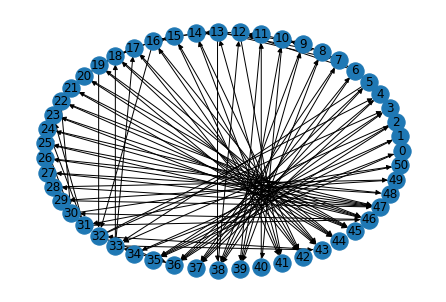

In [5]:
nx.draw_circular(molecule_lg.to_networkx(), with_labels=True)

In [71]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, activation: str = None) -> None:
        super().__init__()
        self._linear = nn.Linear(in_feats, out_feats)
        self._activation = activation

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self._linear(inputs)

        if self._activation == 'relu':
            x = F.relu(x)
        elif self._activation == 'relu6':
            x = F.relu6(x)
        elif self._activation == 'leaky_relu':
            x = F.leaky_relu(x)
        elif self._activation == 'elu':
            x = F.elu(x)
        elif self._activation == 'selu':
            x = F.selu(x)
        elif self._activation == 'celu':
            x = F.celu(x)

        return x

class BilinearReadoutLayer(nn.Module):
    def __init__(self, node_in_feats: int, edge_in_feats: int, out_feats: int, activation: str = None) -> None:
        super().__init__()
        self._bilinear = nn.Bilinear(node_in_feats, edge_in_feats, out_feats)
        self._activation = activation

    def forward(self, node_inputs: torch.Tensor, edge_inputs: torch.Tensor) -> float:
        x = self._bilinear(node_inputs, edge_inputs)
        
        if self._activation == 'relu':
            x = F.relu(x)
        elif self._activation == 'softplus':
            x = F.softplus(x)

        return x


class MutualMultiAttentionHead(nn.Module):
    def __init__(
        self,
        node_in_feats: int,
        edge_in_feats: int,
        num_heads: int,
        short_residual: bool,
        dropout_probability: float,
        message_aggregation_type: str,
        head_pooling_type: str,
        linear_projection_activation: str = None,
    ) -> None:
        super().__init__()
        self._node_in_feats = node_in_feats
        self._edge_in_feats = edge_in_feats
        self._num_heads = num_heads
        self._short_residual = short_residual
        self._message_aggregation_type = message_aggregation_type
        self._head_pooling_type = head_pooling_type
        self._node_query_linear = LinearLayer(node_in_feats, num_heads * node_in_feats, linear_projection_activation)
        self._node_key_linear = LinearLayer(node_in_feats, num_heads, linear_projection_activation)
        self._node_value_linear = LinearLayer(node_in_feats, num_heads * node_in_feats, linear_projection_activation)
        self._edge_query_linear = LinearLayer(edge_in_feats, num_heads * edge_in_feats, linear_projection_activation)
        self._edge_key_linear = LinearLayer(edge_in_feats, num_heads, linear_projection_activation)
        self._edge_value_linear = LinearLayer(edge_in_feats, num_heads * edge_in_feats, linear_projection_activation)
        self._node_dropout = nn.Dropout(dropout_probability)
        self._edge_dropout = nn.Dropout(dropout_probability)

    def _calculate_self_attention(self, query: torch.Tensor, key: torch.Tensor, in_feats: int, short_residual: torch.Tensor = None) -> torch.Tensor:
        if short_residual is not None:
            x = query @ short_residual.T @ key
        else:
            x = query @ torch.transpose(query, -1, -2) @ key

        x /= math.sqrt(in_feats)
        x = F.softmax(x, dim=1)

        return x

    def _create_node_attention_projection(self, g: dgl.DGLGraph, edge_self_attention: torch.Tensor) -> torch.Tensor:
        node_attention_projection = torch.zeros([self._num_heads, g.num_nodes(), g.num_nodes()])

        for edge in range(g.num_edges()):
            nodes = g.find_edges(edge)

            source = nodes[0].item()
            destination = nodes[1].item()

            for head in range(self._num_heads):
                attention_score = edge_self_attention[head][edge]

                node_attention_projection[head][source][destination] = attention_score

            return node_attention_projection

    def _create_edge_attention_projection(self, g: dgl.DGLGraph, lg: dgl.DGLGraph, node_self_attention: torch.Tensor) -> torch.Tensor:
        edge_attention_projection = torch.zeros([self._num_heads, g.num_edges(), g.num_edges()])

        for node in range(lg.num_edges()):
            edges = lg.find_edges(node)

            source = edges[0].item()
            destination = edges[1].item()

            connecting_node = g.find_edges(source)[1].item()

            for head in range(self._num_heads):
                attention_score = node_self_attention[head][connecting_node]

                edge_attention_projection[head][source][destination] = attention_score

            return edge_attention_projection

    def _calculate_message_passing(self, g: dgl.DGLGraph, value: torch.Tensor, attention_projection: torch.Tensor):
        adjacency = g.adj().to_dense()

        if self._message_aggregation_type == 'sum':
            x = attention_projection * adjacency
        elif self._message_aggregation_type == 'mean':
            degree_inv = torch.linalg.inv(torch.diag(g.in_degrees().float()))

            x = degree_inv @ attention_projection * adjacency
        elif self._message_aggregation_type == 'gcn':
            degree_inv_sqrt = torch.sqrt(torch.linalg.inv(torch.diag(g.in_degrees().float())))
            adjacency_inv_sqrt = torch.sqrt(torch.linalg.inv(adjacency))

            x = degree_inv_sqrt @ attention_projection * adjacency_inv_sqrt @ degree_inv_sqrt

        message_passing = x @ value

        return message_passing

    def forward(
        self, 
        g: dgl.DGLGraph, 
        lg: dgl.DGLGraph, 
        node_inputs: torch.Tensor, 
        edge_inputs: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_query = self._node_query_linear(node_inputs)
        node_query = node_query.view(self._num_heads, -1, self._node_in_feats)
        node_key = self._node_key_linear(node_inputs)
        node_key = node_key.view(self._num_heads, -1, 1)
        node_value = self._node_value_linear(node_inputs)
        node_value = node_value.view(self._num_heads, -1, self._node_in_feats)

        edge_query = self._edge_query_linear(edge_inputs)
        edge_query = edge_query.view(self._num_heads, -1, self._edge_in_feats)
        edge_key = self._edge_key_linear(edge_inputs)
        edge_key = edge_key.view(self._num_heads, -1, 1)
        edge_value = self._edge_value_linear(edge_inputs)
        edge_value = edge_value.view(self._num_heads, -1, self._edge_in_feats)

        if self._short_residual:
            node_self_attention = self._calculate_self_attention(node_query, node_key, self._node_in_feats, node_inputs)
            edge_self_attention = self._calculate_self_attention(edge_query, edge_key, self._edge_in_feats, edge_inputs)
        else:
            node_self_attention = self._calculate_self_attention(node_query, node_key, self._node_in_feats)
            edge_self_attention = self._calculate_self_attention(edge_query, edge_key, self._edge_in_feats)

        node_attention_projection = self._create_node_attention_projection(g, edge_self_attention)
        edge_attention_projection = self._create_edge_attention_projection(g, lg, node_self_attention)

        node_message_passing = self._calculate_message_passing(g, node_value, node_attention_projection)
        edge_message_passing = self._calculate_message_passing(lg, edge_value, edge_attention_projection)

        node_message_passing = self._node_dropout(node_message_passing)
        edge_message_passing = self._edge_dropout(edge_message_passing)

        if self._head_pooling_type == 'sum':
            node_message_passing = node_message_passing.sum(dim=-3)
            edge_message_passing = edge_message_passing.sum(dim=-3)
        elif self._head_pooling_type == 'mean':
            node_message_passing = node_message_passing.mean(dim=-3)
            edge_message_passing = edge_message_passing.mean(dim=-3)

        return node_message_passing, edge_message_passing


class MutualAttentionTransformerLayer(nn.Module):
    def __init__(
        self,
        node_in_feats: int,
        node_out_feats: int,
        edge_in_feats: int,
        edge_out_feats: int,
        num_heads: int,
        short_residual: bool,
        long_residual: bool,
        dropout_probability: float,
        message_aggregation_type: str,
        head_pooling_type: str,
        normalization_type: str,
        linear_projection_activation: str = None,
        linear_embedding_activation: str = None,
    ) -> None:
        super().__init__()
        self._long_residual = long_residual
        self._mutual_multi_attention_head = MutualMultiAttentionHead(
            node_in_feats,
            edge_in_feats,
            num_heads,
            short_residual,
            dropout_probability,
            message_aggregation_type,
            head_pooling_type,
            linear_projection_activation,
        )
        self._node_linear_embedding = LinearLayer(node_in_feats, node_out_feats, linear_embedding_activation)
        self._edge_linear_embedding = LinearLayer(edge_in_feats, edge_out_feats, linear_embedding_activation)

        if normalization_type == 'layer':
            self._node_normalization_1 = nn.LayerNorm(node_in_feats)
            self._node_normalization_2 = nn.LayerNorm(node_out_feats)

            self._edge_normalization_1 = nn.LayerNorm(edge_in_feats)
            self._edge_normalization_2 = nn.LayerNorm(edge_out_feats)
        elif normalization_type == 'batch':
            self._node_normalization_1 = nn.BatchNorm1d(node_in_feats)
            self._node_normalization_2 = nn.BatchNorm1d(node_out_feats)

            self._edge_normalization_1 = nn.BatchNorm1d(edge_in_feats)
            self._edge_normalization_2 = nn.BatchNorm1d(edge_out_feats)

    def forward(
        self, 
        g: dgl.DGLGraph, 
        lg: dgl.DGLGraph, 
        node_inputs: torch.Tensor, 
        edge_inputs: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_embedding, edge_embedding = self._mutual_multi_attention_head(g, lg, node_inputs, edge_inputs)

        if self._long_residual:
            node_embedding += node_inputs
            edge_embedding += edge_inputs

        node_embedding = self._node_normalization_1(node_embedding)
        edge_embedding = self._edge_normalization_1(edge_embedding)

        node_embedding = self._node_linear_embedding(node_embedding)
        edge_embedding = self._edge_linear_embedding(edge_embedding)

        node_embedding = self._node_normalization_2(node_embedding)
        edge_embedding = self._edge_normalization_2(edge_embedding)

        return node_embedding, edge_embedding


class GraphMutualAttentionTransformer(nn.Module):
    def __init__(
        self,
        node_in_feats: int,
        node_hidden_feats: int,
        node_out_feats: int,
        edge_in_feats: int,
        edge_hidden_feats: int,
        edge_out_feats: int,
        num_layers: int,
        num_heads: int,
        short_residual: bool,
        long_residual: bool,
        dropout_probability: float,
        message_aggregation_type: str,
        head_pooling_type: str,
        readout_pooling_type: str,
        normalization_type: str,
        linear_projection_activation: str = None,
        linear_embedding_activation: str = None,
        bilinear_readout_activation: str = None,
    ) -> None:
        super().__init__()
        self._node_out_feats = node_out_feats
        self._edge_out_feats = edge_out_feats
        self._num_layers = num_layers
        self._readout_pooling_type = readout_pooling_type
        self._transformer_layers = self._create_transformer_layers(
            node_in_feats,
            node_hidden_feats,
            node_out_feats,
            edge_in_feats,
            edge_hidden_feats,
            edge_out_feats,
            num_layers,
            num_heads,
            short_residual,
            long_residual,
            dropout_probability,
            message_aggregation_type,
            head_pooling_type,
            normalization_type,
            linear_projection_activation,
            linear_embedding_activation,
        )
        self._bilinear_readout = BilinearReadoutLayer(node_out_feats, edge_out_feats, 1, bilinear_readout_activation)


    def _create_transformer_layers(
        self,
        node_in_feats: int,
        node_hidden_feats: int,
        node_out_feats: int,
        edge_in_feats: int,
        edge_hidden_feats: int,
        edge_out_feats: int,
        num_layers: int,
        num_heads: int,
        short_residual: bool,
        long_residual: bool,
        dropout_probability: float,
        message_aggregation_type: str,
        head_pooling_type: str,
        normalization_type: str,
        linear_projection_activation: str = None,
        linear_embedding_activation: str = None,
    ) -> nn.ModuleList:
        transformer_layers = nn.ModuleList()

        if num_layers > 1:
            transformer_layers.append(MutualAttentionTransformerLayer(
                node_in_feats,
                node_hidden_feats,
                edge_in_feats,
                edge_hidden_feats,
                num_heads,
                short_residual,
                long_residual,
                dropout_probability,
                message_aggregation_type,
                head_pooling_type,
                normalization_type,
                linear_projection_activation,
                linear_embedding_activation,
            ))

            for _ in range(num_layers - 2):
                transformer_layers.append(MutualAttentionTransformerLayer(
                    node_hidden_feats,
                    node_hidden_feats,
                    edge_hidden_feats,
                    edge_hidden_feats,
                    num_heads,
                    short_residual,
                    long_residual,
                    dropout_probability,
                    message_aggregation_type,
                    head_pooling_type,
                    normalization_type,
                    linear_projection_activation,
                    linear_embedding_activation,
                ))

            transformer_layers.append(MutualAttentionTransformerLayer(
                node_hidden_feats,
                node_out_feats,
                edge_hidden_feats,
                edge_out_feats,
                num_heads,
                short_residual,
                long_residual,
                dropout_probability,
                message_aggregation_type,
                head_pooling_type,
                normalization_type,
                linear_projection_activation,
                linear_embedding_activation,
            ))
        else:
            transformer_layers.append(MutualAttentionTransformerLayer(
                node_in_feats,
                node_out_feats,
                edge_in_feats,
                edge_out_feats,
                num_heads,
                short_residual,
                long_residual,
                dropout_probability,
                message_aggregation_type,
                head_pooling_type,
                normalization_type,
                linear_projection_activation,
                linear_embedding_activation,
            ))

        return transformer_layers

    def forward(
        self, 
        g: dgl.DGLGraph, 
        lg: dgl.DGLGraph, 
        node_inputs: torch.Tensor, 
        edge_inputs: torch.Tensor,
    ) -> torch.Tensor:
        node_embedding = node_inputs
        edge_embedding = edge_inputs

        for transformer_layer in self._transformer_layers:
            node_embedding, edge_embedding = transformer_layer(g, lg, node_inputs, edge_inputs)

        if self._readout_pooling_type == 'sum':
            node_embedding = node_embedding.sum(dim=-2)
            edge_embedding = edge_embedding.sum(dim=-2)
        elif self._readout_pooling_type == 'mean':
            node_embedding = node_embedding.mean(dim=-2)
            edge_embedding = edge_embedding.mean(dim=-2)
        
        readout = self._bilinear_readout(node_embedding, edge_embedding)

        return readout

In [81]:
node_inputs = molecule.ndata['feat'].float()
edge_inputs = molecule.edata['feat'].float()

model = GraphMutualAttentionTransformer(
    node_in_feats=9,
    node_hidden_feats=9,
    node_out_feats=9,
    edge_in_feats=3,
    edge_hidden_feats=3,
    edge_out_feats=3,
    num_layers=3,
    num_heads=16,
    short_residual=True,
    long_residual=True,
    dropout_probability=0.01,
    message_aggregation_type='mean',
    head_pooling_type='sum',
    readout_pooling_type='mean',
    normalization_type='layer',
    linear_projection_activation='relu',
    linear_embedding_activation='relu',
    bilinear_readout_activation='softplus',
)

# layer_1 = MutualAttentionTransformerLayer(
#     node_in_feats=9,
#     node_out_feats=9,
#     edge_in_feats=3,
#     edge_out_feats=3,
#     num_heads=16,
#     short_residual=True,
#     long_residual=True,
#     dropout_probability=0.1,
#     message_aggregation_type='mean',
#     head_pooling_type='sum',
#     normalization_type='layer',
#     linear_projection_activation='relu',
#     linear_embedding_activation='relu',
# )
# layer_2 = MutualAttentionTransformerLayer(
#     node_in_feats=9,
#     node_out_feats=9,
#     edge_in_feats=3,
#     edge_out_feats=3,
#     num_heads=16,
#     short_residual=True,
#     long_residual=True,
#     dropout_probability=0.1,
#     message_aggregation_type='mean',
#     head_pooling_type='sum',
#     normalization_type='layer',
#     linear_projection_activation='relu',
#     linear_embedding_activation='relu',
# )
# layer_3 = MutualAttentionTransformerLayer(
#     node_in_feats=9,
#     node_out_feats=9,
#     edge_in_feats=3,
#     edge_out_feats=3,
#     num_heads=16,
#     short_residual=True,
#     long_residual=True,
#     dropout_probability=0.1,
#     message_aggregation_type='mean',
#     head_pooling_type='sum',
#     normalization_type='layer',
#     linear_projection_activation='relu',
#     linear_embedding_activation='relu',
# )

t0 = default_timer()

for _ in range(100):
    # n, e = layer_1(molecule, molecule_lg, node_inputs, edge_inputs)
    # n, e = layer_2(molecule, molecule_lg, n, e)
    # n, e = layer_3(molecule, molecule_lg, n, e)

    readout = model(molecule, molecule_lg, node_inputs, edge_inputs)

t1 = default_timer()

print((t1 - t0) / 100)

print(readout.item())


0.008010801929049193
0.5853736400604248


In [75]:
torch.transpose(torch.ones([7, 9]), -1, -2).shape

torch.Size([9, 7])

tensor([[0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000]])